In [2]:
import muselsl
import argparse
import time
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowPresets
from brainflow.data_filter import DataFilter, WindowOperations, WaveletTypes, AggOperations, WindowOperations, WaveletDenoisingTypes, WaveletExtensionTypes, NoiseEstimationLevelTypes, ThresholdTypes

import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pygame.mixer


pygame 2.5.2 (SDL 2.28.3, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
pygame.mixer.init()

# Helper Functions

In [4]:
def pad_or_trim(data, target_length):
    '''
    Input: data (coming from EEG recording) with shape (channels, timesteps).
            target_length to either pad or trim the timesteps to the desired level.
        
    Output: A modified version of data which the timesteps trimmed.

    For example, recording with Muse2 can yield 245-255 timesteps due to certain inconsistencies.
    We can use this function to always trim/pad the data recorded and limit it to 250 timesteps (From (8, 245) to (8, 250))

    '''
    if data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), 'constant', constant_values=0)
    else:
        data = data[:, :target_length]
    return data

# Synthetic Board (Testing Functions)

Initializing Board

In [2]:
params = BrainFlowInputParams()
board = BoardShim(BoardIds.SYNTHETIC_BOARD, params)

In [47]:
print(BoardShim.get_sampling_rate(BoardIds.MUSE_2_BOARD))

256


Creating a Stream Session

In [5]:
board.prepare_session()
board.start_stream()


for i in range(5):
    time.sleep(1)
    board.insert_marker(i + 1)

data = board.get_board_data()
board.stop_stream()
board.release_session()

In [22]:
eeg_channels = BoardShim.get_eeg_channels(BoardIds.SYNTHETIC_BOARD)
marker_channel = BoardShim.get_marker_channel(BoardIds.SYNTHETIC_BOARD)

In [43]:
for count, channel in enumerate(eeg_channels):
    wavelet_coeffs, lengths = DataFilter.perform_wavelet_transform(data[channel], WaveletTypes.DB5, 1)
    break

<Axes: >

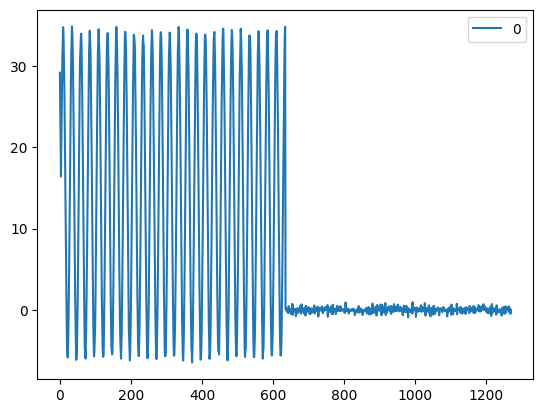

In [44]:
df = pd.DataFrame(wavelet_coeffs)
df.plot()

# Muse2 Board

Board Initialisation

In [5]:
# This is just for testing and developing functions.
board_type = BoardIds.SYNTHETIC_BOARD

In [6]:
params = BrainFlowInputParams()
board = BoardShim(board_type, params)

In [7]:
eeg_channels = BoardShim.get_eeg_channels(board_type)
marker_channel = BoardShim.get_marker_channel(board_type)

Parameters for Data Collection

In [8]:
# This is so we don't overwrite the entire data when we re-run the collection.
session_features = None
session_labels = None

In [9]:
done_sfx = pygame.mixer.Sound('Sound Effects/Enter.mp3')
sampling_freq = BoardShim.get_sampling_rate(board_type) # Muse2's sampling frequency. (How many timesteps per second)
eeg_channels = BoardShim.get_eeg_channels(board_type)

duration = 2 # How long should each sample be? (in seconds)
rest_time = 2 # How many seconds in between each recording?

In [10]:
iterations = 2
midi_note = 1 # Initially, let's just try 1 2 3 for do re mi (think of the word along with the sound)

Data Collection

In [11]:
print("Be sure to only blink during the rest times allocated.")

board.prepare_session()
for i in range(iterations):
    print("Iteration ", i + 1, "/", iterations)
    print("Think of the note: ", midi_note, "in ", rest_time, " second(s).")
    time.sleep(rest_time)

    ## Streaming ##
    board.start_stream()

    time.sleep(duration)

    board.stop_stream()

    if done_sfx:
        done_sfx.play()

    ## End Stream ## 
    ## Start Data Storage ## 
    data = board.get_board_data()
    
    # This pads/trims the data so it's 256 timesteps long (or whatever the sampling frequency is)
    data = pad_or_trim(data, sampling_freq) # -> (channels, sampling_freq) shape. Or (4, 256) for Muse2. [EEG only]

    data = np.expand_dims(data, 0)
    label = np.array([midi_note]) # Saves the current note as a feature.
    if session_features is None:
        session_features = data # This converts our data from (channels, sampling_freq) to (1, channels, sampling_freq) This is just so that all the data can be appended together.
        session_labels = label
    else:
        session_features = np.append(session_features, data, axis=0)
        session_labels = np.append(session_labels, label, axis=0)

    
    # This clears the Python notebook output.
    clear_output()

board.release_session()

Data Processing

In [20]:
# We would have to denoise the data.
### TO IMPLEMENT: Data denoising.
# Refer to this: https://brainflow.readthedocs.io/en/stable/Examples.html#python-denoising
# Note: This function performs denoising IN PLACE.
DataFilter.perform_wavelet_denoising(session_features[0][1],
                                     WaveletTypes.BIOR3_9,
                                     3,
                                     WaveletDenoisingTypes.SURESHRINK,
                                     ThresholdTypes.HARD,
                                     WaveletExtensionTypes.SYMMETRIC,
                                     NoiseEstimationLevelTypes.FIRST_LEVEL
                                     )
# Next, we'd also have to extract the different wave states
# Refer to this: https://brainflow.readthedocs.io/en/stable/Examples.html#python-band-power


# However, through this, we still have the same amount of features. Therefore, we have to extract relevant features
# from each of the wave.